# P03_06_Multivar_tf_supervised




DNN Supervised approach to forecast the ICME 18 ahead.

In [1]:
section_fig_main_title = 'P03_06_Multivar_tf_supervised'

In [2]:
# import os
# print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
# print("PATH:", os.environ.get('PATH'))

In [3]:
import os, sys
import requests
from urllib.parse import urljoin, urlparse
# from bs4 import BeautifulSoup as bs
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pandas.plotting import lag_plot

from tensorflow import keras
from tensorflow.keras import layers


In [4]:
!which python

/Users/amin/miniconda3/bin/python


In [5]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_absolute_error
# from xgboost import XGBRegressor
# !/Users/amin/Desktop/proj/env/bin/python -m pip install numpy

In [6]:
from sklearn.metrics import r2_score,mean_absolute_error

In [7]:
# !/Users/amin/anaconda3/bin/python -m pip install --upgrade tensorflow 
# pip install --upgrade tensorflow 

In [8]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

import math
from sklearn.metrics import mean_squared_error

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [11]:
from pandas.plotting import autocorrelation_plot
import gif

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [13]:
import tensorflow as tf
tf.__version__


'2.6.0'

In [14]:
import gif
from tqdm import tqdm

In [15]:
from sklearn import metrics
import statsmodels.api as sm

## Read Data 

Using the univariate evenly spaced time series data from P03_01.

In [16]:
csv_path = "../Data/Data_ICME_Edited_Decoded_out_P02_03.csv"
dataset = pd.read_csv(csv_path, infer_datetime_format=True)

In [17]:
dataset.index = dataset['ICME Plasma/Field Start Y/M/D (UT) (b)']

In [18]:
dataset.head()

,ICME Plasma/Field Start Y/M/D (UT) (b),ICME Plasma/Field End Y/M/D (UT) (b),BDE? (e),Qual. (g),dV (km/s) (h),V_ICME (km/s) (i),V_max (km/s) (j),B (nT) (k),MC? (l),Dst (nT) (m),Normalized_time_interval
ICME Plasma/Field Start Y/M/D (UT) (b),,,,,,,,,,,
1996-05-27 15:00:00,1996-05-27 15:00:00,1996-05-29 03:00:00,1,2,1,370,400,9,3,117,1.375000
1996-07-01 18:00:00,1996-07-01 18:00:00,1996-07-02 11:00:00,1,4,44,360,370,11,3,78,0.583333
1996-08-07 12:00:00,1996-08-07 12:00:00,1996-08-08 10:00:00,1,2,2,350,380,7,3,88,0.791667
1996-12-23 17:00:00,1996-12-23 17:00:00,1996-12-25 11:00:00,1,2,22,360,420,10,3,69,1.625000
1997-01-10 04:00:00,1997-01-10 04:00:00,1997-01-11 02:00:00,3,1,4,450,460,14,3,191,0.791667


In [19]:
dataset.columns

Index(['ICME Plasma/Field Start Y/M/D (UT) (b)',
       'ICME Plasma/Field End Y/M/D (UT) (b)', 'BDE? (e)', 'Qual. (g)',
       'dV (km/s) (h)', 'V_ICME (km/s) (i)', 'V_max (km/s) (j)', 'B (nT) (k)',
       'MC? (l)', 'Dst (nT) (m)', 'Normalized_time_interval'],
      dtype='object')

Following columns are used for multi-var time series modeling.

```BDE? (e)``` : Evidence of BiDirectional suprathermal Electron strahls (BDE) in ACE/SWEPAM Observations

```MC? (l)``` :  magnetic cloud has been reported in association with the ICME 

```V_ICME (km/s) (i)``` : ICME speed



In [20]:
# keep_cols = ['BDE? (e)', 'Qual. (g)',
#        'dV (km/s) (h)', 'V_ICME (km/s) (i)', 'B (nT) (k)',
#        'MC? (l)', 'Dst (nT) (m)', 'Normalized_time_interval']

keep_cols = ['ICME Plasma/Field Start Y/M/D (UT) (b)' ,'BDE? (e)', 'V_ICME (km/s) (i)','MC? (l)']
dataset = dataset[keep_cols]
dataset.head()

,ICME Plasma/Field Start Y/M/D (UT) (b),BDE? (e),V_ICME (km/s) (i),MC? (l)
ICME Plasma/Field Start Y/M/D (UT) (b),,,,
1996-05-27 15:00:00,1996-05-27 15:00:00,1,370,3
1996-07-01 18:00:00,1996-07-01 18:00:00,1,360,3
1996-08-07 12:00:00,1996-08-07 12:00:00,1,350,3
1996-12-23 17:00:00,1996-12-23 17:00:00,1,360,3
1997-01-10 04:00:00,1997-01-10 04:00:00,3,450,3


In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 493 entries, 1996-05-27 15:00:00 to 2021-05-12 15:00:00
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ICME Plasma/Field Start Y/M/D (UT) (b)  493 non-null    object
 1   BDE? (e)                                493 non-null    int64 
 2   V_ICME (km/s) (i)                       493 non-null    int64 
 3   MC? (l)                                 493 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.3+ KB


## Make Data evenly spaced time series

In [22]:
# fix the date dtype
dataset['ICME Plasma/Field Start Y/M/D (UT) (b)']= pd.to_datetime(dataset['ICME Plasma/Field Start Y/M/D (UT) (b)'])

In [23]:
dataset = dataset.set_index('ICME Plasma/Field Start Y/M/D (UT) (b)').resample('18D').pad()

In [24]:
dataset.head()

,BDE? (e),V_ICME (km/s) (i),MC? (l)
ICME Plasma/Field Start Y/M/D (UT) (b),,,
1996-05-27,NaN,NaN,NaN
1996-06-14,1.0,370.0,3.0
1996-07-02,1.0,360.0,3.0
1996-07-20,1.0,360.0,3.0
1996-08-07,1.0,360.0,3.0


In [25]:
dataset.shape

(507, 3)

In [26]:
# remove first row
dataset = dataset.iloc[1: , :]
dataset.head()

,BDE? (e),V_ICME (km/s) (i),MC? (l)
ICME Plasma/Field Start Y/M/D (UT) (b),,,
1996-06-14,1.0,370.0,3.0
1996-07-02,1.0,360.0,3.0
1996-07-20,1.0,360.0,3.0
1996-08-07,1.0,360.0,3.0
1996-08-25,1.0,350.0,3.0


## Preparing data 

Here I make new data set using pandas library. The shift method is used along with 60 lags. The goal is to use 60 lags (timestamps) to forecast the future timestamps (18 days ahead).

In [27]:
dataset.shift(periods=1)

,BDE? (e),V_ICME (km/s) (i),MC? (l)
ICME Plasma/Field Start Y/M/D (UT) (b),,,
1996-06-14,NaN,NaN,NaN
1996-07-02,1.0,370.0,3.0
1996-07-20,1.0,360.0,3.0
1996-08-07,1.0,360.0,3.0
1996-08-25,1.0,360.0,3.0
...,...,...,...
2021-02-21,3.0,440.0,1.0
2021-03-11,3.0,440.0,1.0
2021-03-29,3.0,510.0,1.0


In [28]:
cols = dataset.columns
cols[0]

'BDE? (e)'

In [29]:
# df_pd

In [30]:
lag=2

In [31]:
df_pd = pd.DataFrame(dataset)
df_pd_shifted = pd.DataFrame(dataset)

cols = dataset.columns

for i in range(1,lag+1):

    
    shifted_df = df_pd.shift(periods=i)
    shifted_df.columns = [(cols[0] + 'lag' + str(i)), 
                          (cols[1] + 'lag' + str(i)), 
                          (cols[2] + 'lag' + str(i))] 
    
    df_pd_shifted = pd.concat([df_pd_shifted, shifted_df], axis=1)
    
    
    
    

# discard the first NaN rows 
df_pd_shifted = df_pd_shifted[lag:]



In [32]:
for i in range(1,lag+1):
    
    for col in cols:
    
        colname = col + 'lag' + str(i) 

        df_pd_shifted[colname].astype('int32').dtypes

In [33]:
df_pd_shifted.head()

,BDE? (e),V_ICME (km/s) (i),MC? (l),BDE? (e)lag1,V_ICME (km/s) (i)lag1,MC? (l)lag1,BDE? (e)lag2,V_ICME (km/s) (i)lag2,MC? (l)lag2
ICME Plasma/Field Start Y/M/D (UT) (b),,,,,,,,,
1996-07-20,1.0,360.0,3.0,1.0,360.0,3.0,1.0,370.0,3.0
1996-08-07,1.0,360.0,3.0,1.0,360.0,3.0,1.0,360.0,3.0
1996-08-25,1.0,350.0,3.0,1.0,360.0,3.0,1.0,360.0,3.0
1996-09-12,1.0,350.0,3.0,1.0,350.0,3.0,1.0,360.0,3.0
1996-09-30,1.0,350.0,3.0,1.0,350.0,3.0,1.0,350.0,3.0


In [34]:
dataset = df_pd_shifted

## Split the data into training and test sets

#### https://www.tensorflow.org/tutorials/keras/regression

In [35]:
# train_dataset = dataset.sample(frac=0.69, random_state=0)
# test_dataset = dataset.drop(train_dataset.index)

In [36]:
split_frac= 0.8
num_train_rows = int(split_frac*len(dataset))
num_test_rows = len(dataset) - num_train_rows

In [37]:
train_dataset, test_dataset = dataset[0:num_train_rows] , dataset[num_train_rows:]

In [38]:
train_dataset

,BDE? (e),V_ICME (km/s) (i),MC? (l),BDE? (e)lag1,V_ICME (km/s) (i)lag1,MC? (l)lag1,BDE? (e)lag2,V_ICME (km/s) (i)lag2,MC? (l)lag2
ICME Plasma/Field Start Y/M/D (UT) (b),,,,,,,,,
1996-07-20,1.0,360.0,3.0,1.0,360.0,3.0,1.0,370.0,3.0
1996-08-07,1.0,360.0,3.0,1.0,360.0,3.0,1.0,360.0,3.0
1996-08-25,1.0,350.0,3.0,1.0,360.0,3.0,1.0,360.0,3.0
1996-09-12,1.0,350.0,3.0,1.0,350.0,3.0,1.0,360.0,3.0
1996-09-30,1.0,350.0,3.0,1.0,350.0,3.0,1.0,350.0,3.0
...,...,...,...,...,...,...,...,...,...
2016-03-01,3.0,410.0,2.0,3.0,410.0,2.0,3.0,410.0,2.0
2016-03-19,1.0,360.0,3.0,3.0,410.0,2.0,3.0,410.0,2.0
2016-04-06,1.0,400.0,2.0,1.0,360.0,3.0,3.0,410.0,2.0


## Split features from labels

In [39]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('V_ICME (km/s) (i)')
test_labels = test_features.pop('V_ICME (km/s) (i)')

## Normalization

In [40]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
BDE? (e),2.210918,0.978719
V_ICME (km/s) (i),442.630273,92.958718
MC? (l),2.225806,0.808000
BDE? (e)lag1,2.210918,0.978719
V_ICME (km/s) (i)lag1,442.531017,93.025679
MC? (l)lag1,2.228288,0.808840
BDE? (e)lag2,2.210918,0.978719
V_ICME (km/s) (i)lag2,442.456576,93.071790
MC? (l)lag2,2.230769,0.809672


## The Normalization layer

In [41]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [42]:
normalizer.adapt(np.array(train_features))

2021-10-28 13:08:32.660396: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 13:08:32.725166: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [43]:
print(normalizer.mean.numpy())

[[  2.2109182   2.2258067   2.2109182 442.53098     2.2282877   2.2109182
  442.45657     2.2307692]]


In [44]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[  1.   3.   1. 360.   3.   1. 370.   3.]]

Normalized: [[-1.24  0.96 -1.24 -0.89  0.96 -1.24 -0.78  0.95]]


In [45]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim(0,)
    plt.xlabel('Epoch')
    plt.ylabel('Error V_ICME (km/s) (i)')
    plt.legend()
    plt.grid(True)

## Regression using a DNN and multiple inputs

In [46]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(8, activation='relu'),
#       layers.Dense(32, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [47]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 98
Trainable params: 81
Non-trainable params: 17
_________________________________________________________________


In [48]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=2000)

CPU times: user 53.8 s, sys: 5.56 s, total: 59.3 s
Wall time: 47.1 s


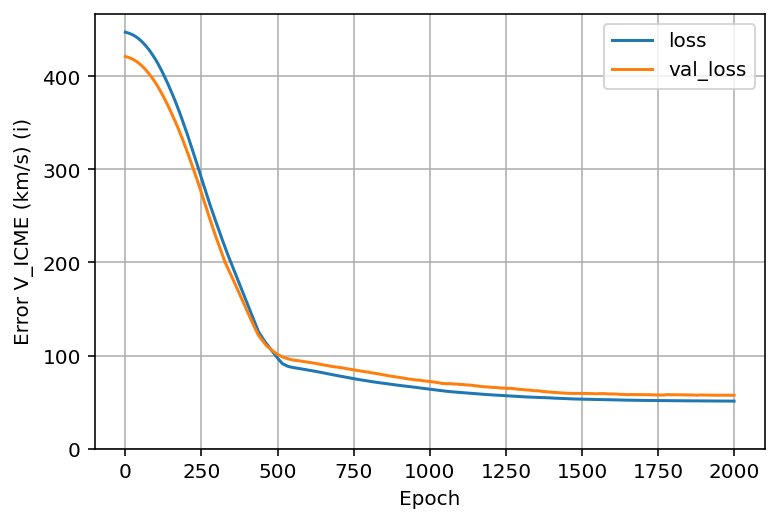

In [49]:
plot_loss(history)

(200.0, 650.0)

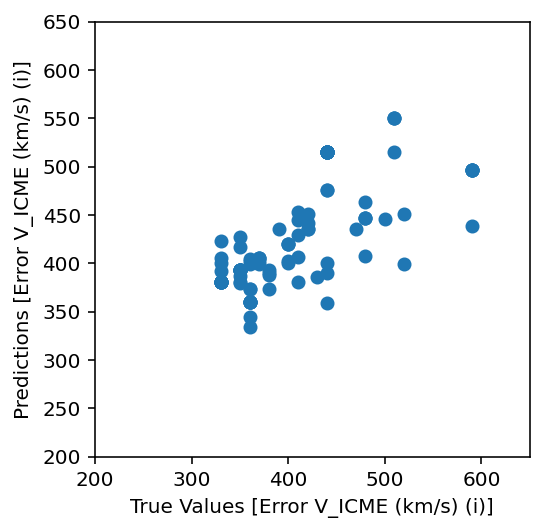

In [50]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Error V_ICME (km/s) (i)]')
plt.ylabel('Predictions [Error V_ICME (km/s) (i)]')
lims = [200, 650]
plt.xlim(lims)
plt.ylim(lims)
# _ = plt.plot(lims, lims)

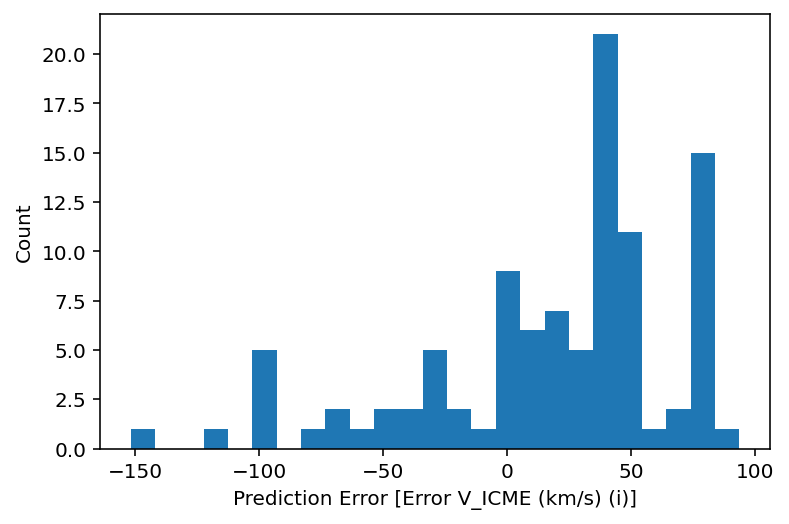

In [51]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Error V_ICME (km/s) (i)]')
_ = plt.ylabel('Count')

In [52]:
len(train_labels)

403

In [53]:
test_predictions

array([419.80954, 419.80954, 419.80954, 400.529  , 451.03952, 441.35245,
       435.69247, 435.69247, 435.69247, 379.96494, 344.80563, 334.20694,
       360.00052, 360.00052, 360.00052, 360.00052, 360.00052, 360.00052,
       373.53052, 387.81644, 389.95224, 373.87213, 373.12637, 399.06552,
       451.45728, 446.20724, 438.1419 , 496.2316 , 496.75195, 496.75195,
       496.75198, 496.75198, 463.23486, 407.8919 , 446.90463, 446.90463,
       446.90463, 444.67728, 452.84793, 429.58798, 385.50336, 402.7887 ,
       400.37436, 423.4835 , 400.5621 , 380.75204, 380.75204, 406.9479 ,
       389.96286, 476.38367, 515.2178 , 515.2178 , 515.2178 , 515.2178 ,
       515.2178 , 515.2178 , 515.2178 , 515.2178 , 515.2178 , 515.2178 ,
       435.71286, 416.827  , 426.92108, 392.96103, 392.961  , 392.961  ,
       392.961  , 392.961  , 392.961  , 392.961  , 392.961  , 402.7845 ,
       404.72552, 399.06552, 399.06552, 402.34   , 405.17   , 405.17   ,
       405.17   , 405.17   , 392.07205, 380.75204, 

In [54]:
test_labels

ICME Plasma/Field Start Y/M/D (UT) (b)
2016-05-30    400.0
2016-06-17    400.0
2016-07-05    400.0
2016-07-23    440.0
2016-08-10    420.0
              ...  
2021-02-21    440.0
2021-03-11    510.0
2021-03-29    510.0
2021-04-16    510.0
2021-05-04    510.0
Freq: 18D, Name: V_ICME (km/s) (i), Length: 101, dtype: float64

In [55]:
yhat_ser = pd.Series(test_predictions)
yhat_ser.index = test_labels.index

In [56]:
# train_features = train_dataset.copy()
# test_features = test_dataset.copy()

# train_labels = train_features.pop('V_ICME (km/s) (i)')
# test_labels = test_features.pop('V_ICME (km/s) (i)')

In [57]:
len(train_labels)

403

In [64]:
len(test_labels)

101

In [77]:
@gif.frame
def plott(ahead):
    
    ahead = ahead
    past = 100


    testy = test_labels
    yhat = yhat_ser



    plt.figure(figsize=(16,8))

    plt.plot(train_labels[len(train_labels)-past:], 'r',label='history')
    plt.vlines(train_labels[len(train_labels)-1:len(train_labels)].index,0, 700, colors='k', linestyles='dashed')

    plt.plot(testy[0:ahead], 'r^',label='Test')
    plt.plot(testy[0:ahead], 'r')
    #     test.plot(kind='scatter')

    plt.plot(yhat[0:ahead], color='blue',label='Predicted')
    plt.title('DNN model', fontsize=10)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('ICME km/s', fontsize=10)


    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)


    plt.legend(fontsize=10)
    # plt.ylim(200,)

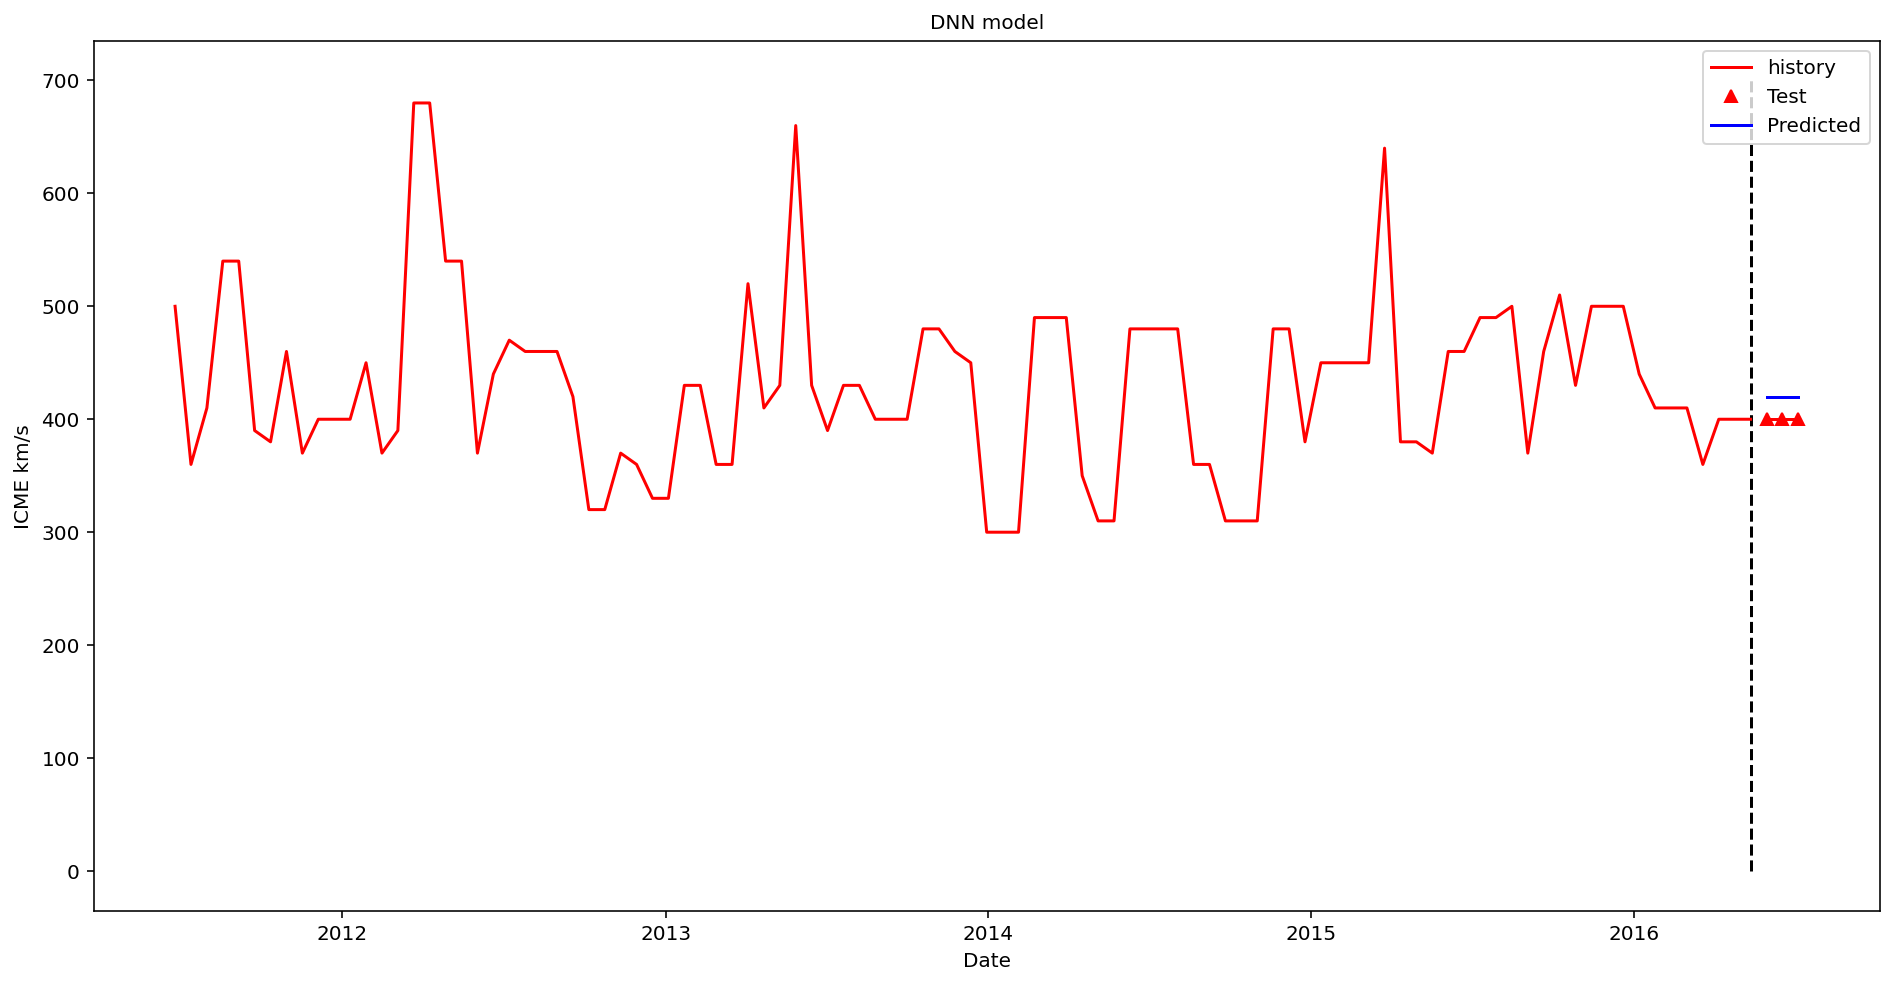

In [73]:
plott(ahead=3)

## GIF visualization

In [78]:
frames = []    
for i in tqdm(range(0,len(test_labels)+1)):

    
    frame =  plott(i)
    frames.append(frame)

100%|█████████████████████████████████████████| 102/102 [00:26<00:00,  3.81it/s]


In [81]:
gif.save(frames, "../Figures/P03_06_DNN_multivar_sup.gif", duration=1)

## rs2

In [59]:
real_values = test_labels
predited_values = test_predictions

coefficient_of_dermination = r2_score(real_values, predited_values)
coefficient_of_dermination

rs2 = round(coefficient_of_dermination,2)
print(rs2)

0.41


## MAE

In [60]:
mae = mean_absolute_error(real_values, predited_values)
mae = round(mae, 2)
mae

44.95

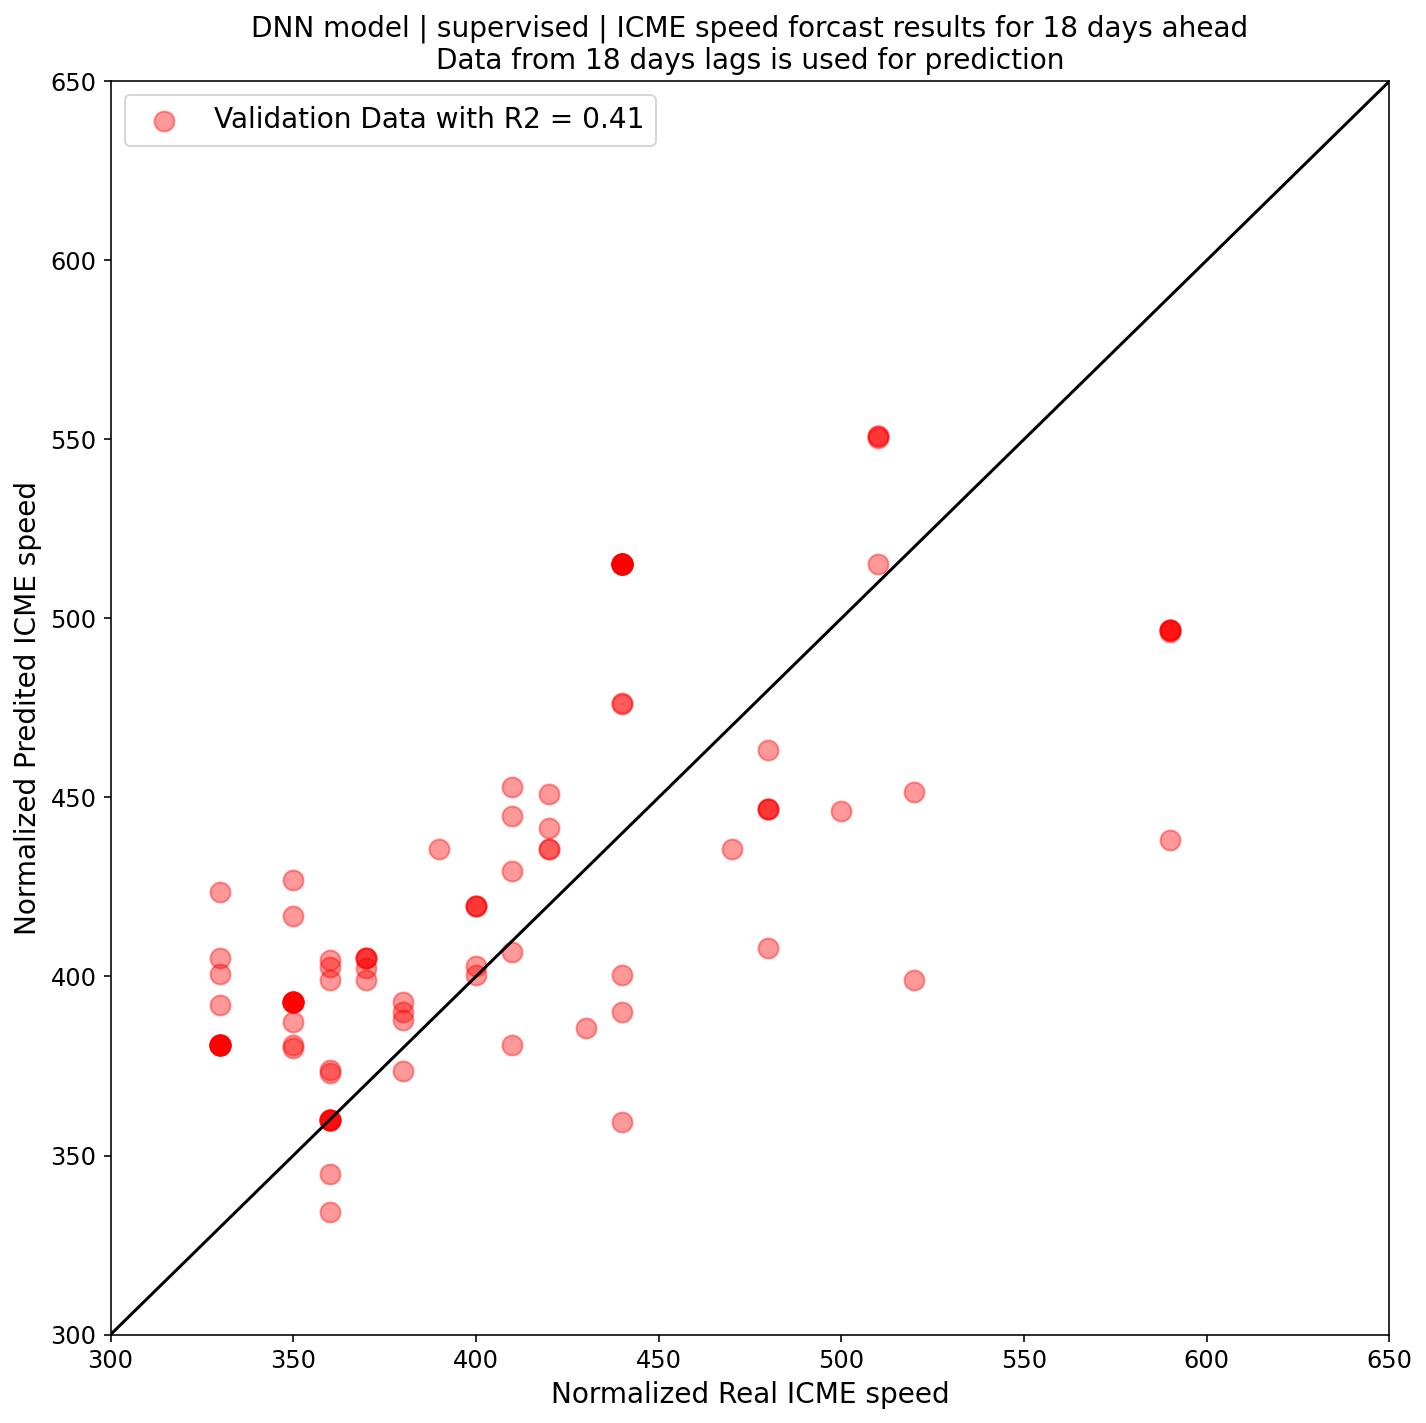

In [62]:
plt.figure(figsize=(10,10))


real_values = test_labels
predited_values = test_predictions


plt.scatter(real_values, predited_values, color='r', 
            alpha=0.4, label=f'Validation Data with R2 = {rs2}',s=100)
plt.xlabel("Normalized Real ICME speed", fontsize=14)
plt.ylabel("Normalized Predited ICME speed", fontsize=14)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.axline([0, 0], [1, 1], color ='k')
# plt.hlines(0, -4, 4, linestyles="--", color ='k')
# plt.vlines(0, -4, 4, linestyles="--", color ='k')

lims = [300, 650]
plt.xlim(lims)
plt.ylim(lims)

plt.title("DNN model | supervised | ICME speed forcast results for 18 \
days ahead\nData from 18 days lags is used for prediction", fontsize=14)

plt.tight_layout()
plt.legend(fontsize=14)

plt.savefig("../Figures/" + section_fig_main_title + "DNN18daysAhead.png")

In [63]:
dnn_model.save('../Models/dnn_model_tf_p03_06')

2021-10-28 13:10:01.469567: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../Models/dnn_model_tf_p03_06/assets


The DNN does not encounter overfitting however applying small networks is not helpful. Applying split fraction 0.8 results in improved MAE values.
2 lags (2*18 days) data was used for prediction next timestamps.